In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
import astropy.table
import astropy.io.fits as fits
import astropy.units as u
import logging
import six



import poppy
import poppy.zernike as zernike
import webbpsf
from webbpsf import constants
from webbpsf import utils

from copy import deepcopy
from webbpsf import optics
from scipy import io


In [55]:
class OteThermalModel(object):
    """
    Given a time in units of seconds, minutes, hours, or days.


    """
    def __init__(self, time, npix=1024, nterms=9):
        # Files
        full_seg_mask_file = os.path.join(utils.get_webbpsf_data_path(), 'JWpupil_segments.fits')
        datafile = os.path.join(utils.get_webbpsf_data_path(), 'OPD_per_seg_gn_tau_9z.fits')
        
        # Define shape and size of segments
        pixelscale = 0.006526714427860697 #FIXME where does this come from??
        self.segids = np.asarray([a[0:2] for a in constants.SEGNAMES_WSS_ORDER])
        self.segradius = constants.JWST_SEGMENT_RADIUS / pixelscale
        self.seg_centers_pixels = {seg[0:2]: npix/2+ np.asarray(cen)/pixelscale
                                   for seg, cen in constants.JWST_PRIMARY_SEGMENT_CENTERS}

        segment_masks = fits.getdata(full_seg_mask_file)
        self.labeldict = {}
        for segment in self.segids:
            iseg = np.where(self.segids == segment)[0][0]+1  # segment index from 1 - 18
            wseg = np.zeros_like(segment_masks)
            wseg[segment_masks==iseg] = iseg
            self.labeldict[segment] = wseg

        # Create delta OPD from Gain and Tau terms (datafile)
        self.npix = npix
        self.nterms = nterms
        self.time = OteThermalModel.convert_time(time)

        gtdata = fits.getdata(datafile)                                                                    
        self.delta_opd = self.create_full_opd(gtdata)


    # Generic Functions
    @staticmethod
    def convert_time(time):
        #FIXME make sure we know what the default should be here
        '''
        Pass in a given astropy units quantity with units in time (second, minute,
        hour, day, etc). If no quantity given, assume **minutes**.

        Returns a quantity with units of "day"
        '''
        try:
            time.to(u.day)
        except AttributeError:
            time *= u.minute
            time.to(u.day)

        return time.value

    # Create thermal opd

    def define_rho_theta(self, npix, segid):
        x = (np.arange(npix, dtype=np.float64) - self.seg_centers_pixels[segid][1]) / self.segradius
        y = (np.arange(npix, dtype=np.float64) - self.seg_centers_pixels[segid][0]) / self.segradius
        xx, yy = np.meshgrid(x, y)
        rho = np.sqrt(xx ** 2 + yy ** 2)
        theta = np.arctan2(yy, xx)
        return rho, theta

    def get_zcoeffs(self, segid, gtdata):
        '''
        Time in days
        '''
        zcoeffs = []
        for i, (gain, tau) in enumerate(zip(gtdata[gtdata['segs'] == segid]['G_n'],
                                          gtdata[gtdata['segs'] == segid]['tau'])):
            if gtdata['zs' == i]:
                zcoeffs.append(OteThermalModel.func(self.time, tau, gain))
        return zcoeffs
    
        

    @staticmethod
    def func(x, tau, gn):
        '''
        First order thermal response function
        '''
        return gn*(1-np.exp(-1*(x/tau)))


    def create_full_opd(self, gtdata):
        '''
        Create a full opd based on zernike information
        '''
        def get_basis(*args, **kwargs):
            '''opd_from_zernikes requires a basis to be created in this way'''
            return basis

        opd_z = np.zeros((self.npix, self.npix))
        for segid in self.segids:
            cn = self.get_zcoeffs(segid, gtdata)
            rho, theta = self.define_rho_theta(self.npix, segid)
            # basis = poppy.zernike.arbitrary_basis(LABELDICT[segid] > 0.,
            #                                       nterms=len(cn), rho=rho,
            #                                       theta=theta)

            basis = poppy.zernike.hexike_basis_wss(nterms=self.nterms, npix=self.npix,
                                                   rho=rho, theta=theta)
            opd_z += (poppy.zernike.opd_from_zernikes(cn, basis=get_basis,
                                                      aperture=self.labeldict[segid] > 0.))
        return opd_z


In [56]:
time = 15*u.minute
opd = OteThermalModel(time)

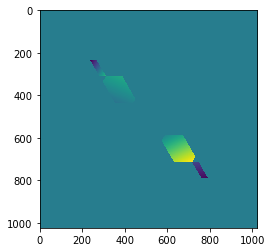

In [59]:
plt.imshow(opd.delta_opd)
plt.show()